## Load the data and import the libraries

In [1]:
import sys
sys.path.append('src')

from feature_engineering import (
    create_fico_score,
    create_fico_band,
    log_transform,
    calculate_credit_history_years,
    create_binary_flags,
    create_vintage_features,
    create_dti_adjusted,
    calculate_iv
)

from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import category_encoders as ce
from imblearn.over_sampling import SMOTE
import joblib
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier

In [2]:
url = "https://www.dropbox.com/scl/fi/gxskg98izg6fmulp22n3r/accepted_2007_to_2018Q4.csv?rlkey=1jl9t026rlg5o009wbf9rbog0&st=eas942l3&dl=1"
df_accepted = pd.read_csv(url, low_memory=False)

## Implement the transformations already used in the EDA

In [3]:
df_accepted = df_accepted.drop_duplicates()
df = df_accepted.loc[:, df_accepted.isnull().sum() / len(df_accepted) < 0.01]

# Split categorical and numerical columns
num_cols = df.select_dtypes(include='number').columns
cat_cols = df.select_dtypes(exclude='number').columns

# Imputers
mean_imputer = SimpleImputer(strategy='mean')
mode_imputer = SimpleImputer(strategy='most_frequent')

df.loc[:, num_cols] = mean_imputer.fit_transform(df[num_cols])
df.loc[:, cat_cols] = mode_imputer.fit_transform(df[cat_cols])

# Issue_d to datetime
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y', errors='coerce')

# Copy the dataset for good practice
df = df.copy()

default_status = ['Charged Off', 'Default', 'Late (31-120 days)', 'Does not meet the credit policy. Status:Charged Off']

# Create binary target
df['default'] = df['loan_status'].isin(default_status).astype(int)

# Performance loans for comparison
performing_status = ['Fully Paid', 'Current']
df['performing'] = df['loan_status'].isin(performing_status).astype(int)

### Data leakage variables removal

In [4]:
# Data leakage variables to remove
data_leakage_vars = [
    # Payment information (post-origination)
    'last_pymnt_amnt',
    'last_pymnt_d',
    'total_pymnt',
    'total_pymnt_inv',
    'total_rec_prncp',
    'total_rec_int',
    'total_rec_late_fee',

    # Outstanding balances (change over time)
    'out_prncp',
    'out_prncp_inv',

    # Recovery information (post-default)
    'recoveries',
    'collection_recovery_fee',

    # Status flags (known after origination)
    'debt_settlement_flag',
    'debt_settlement_flag_date',
    'settlement_status',
    'settlement_date',
    'settlement_amount',
    'settlement_percentage',
    'settlement_term',

    # Hardship information
    'hardship_flag',
    'hardship_type',
    'hardship_status',
    'hardship_start_date',
    'hardship_end_date',
    'hardship_loan_status',
    'hardship_payoff_balance_amount',
    'hardship_last_payment_amount',

    # Credit monitoring (post-origination)
    'last_credit_pull_d',
    'next_pymnt_d'
]

# Remove leakage variables
print(f"Original dataset shape: {df.shape}")
df = df.drop(columns=data_leakage_vars, errors='ignore')
print(f"After removing data leakage: {df.shape}")
print(f"Removed {len(data_leakage_vars)} potential leakage variables")

# Verify complete removal
remaining_leakage = [col for col in data_leakage_vars if col in df.columns]
if remaining_leakage:
    print(f"\n Warning: The following leakage variables remain: {remaining_leakage}")
else:
    print("\n All data leakage variables successfully removed")

Original dataset shape: (2260701, 58)
After removing data leakage: (2260701, 44)
Removed 28 potential leakage variables

 All data leakage variables successfully removed


In [5]:
# Apply the log transformation
df["annual_inc_log1p"] = log_transform(df['annual_inc'])

In [6]:
# FICO midpoint (industry standard)
df['fico_score'] = create_fico_score(df, 'fico_range_low', 'fico_range_high' )

# FICO bands for scorecard development
df['fico_band'] = create_fico_band(df['fico_score'])

# Credit history length (years)
df['credit_history_years'] = calculate_credit_history_years(df, 'earliest_cr_line', 'issue_d')

# Behavioral flags
df = create_binary_flags(df)

# Vintage features
df = create_vintage_features(df, 'issue_d')

# Loan age/seasoning (months from origination to observation date)
observation_date = pd.to_datetime('2018-12-01')
df['loan_age_months'] = (observation_date - df['issue_d']).dt.days / 30

## Feature engineering

In [7]:
# Define model features (excluding target and identifiers)
model_features = [
    # Loan characteristics
    'loan_amnt', 'int_rate', 'installment',

    # Borrower financials
    'annual_inc', 'annual_inc_log1p', 'dti',

    # Credit bureau data
    'fico_score', 'delinq_2yrs', 'inq_last_6mths',
    'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
    'total_acc',

    # Engineered features
    'credit_history_years', 'has_delinquency',
    'has_public_records', 'has_bankruptcy',

    # Categorial variables
    'term', 'pymnt_plan', 'application_type', 'disbursement_method',
    'grade', 'sub_grade', 'home_ownership', 'purpose', 'fico_band'

]

#### Information Value (IV)

Information Value (IV) is a statistical metric used in credit risk modeling to measure the predictive power of a feature in distinguishing between binary outcomes (e.g., default vs non-default).

For feature selection in a credit risk model, we calculate IV for all candidate features. Variables with IV > 0.5 should be investigated for data leakage or target correlation issues.

In [8]:
# Evaluate all features
iv_results = {}
for feature in model_features:
    try:
        iv_results[feature] = calculate_iv(df, feature, 'default')
    except Exception as e:
        print(f"Error calculating IV for {feature}: {e}")
        iv_results[feature] = np.nan

# Visualize IV scores
iv_df = pd.DataFrame(iv_results, index=['IV']).T.sort_values('IV', ascending=False)

print("INFORMATION VALUE (IV) - FEATURE SELECTION")
print(iv_df)
print("IV Interpretation:")
print("  < 0.02  : Not predictive")
print("  0.02-0.1: Weak predictor")
print("  0.1-0.3 : Medium predictor")
print("  0.3-0.5 : Strong predictor")
print("  > 0.5   : Suspicious (possible data leakage)")

# Filter features by IV threshold
strong_features = iv_df[iv_df['IV'] > 0.1].index.tolist()
print(f"\nStrong predictors (IV > 0.1): {len(strong_features)} features")
print(strong_features)

INFORMATION VALUE (IV) - FEATURE SELECTION
                            IV
sub_grade             0.515099
grade                 0.478198
int_rate              0.437794
fico_score            0.157252
fico_band             0.108111
term                  0.066602
disbursement_method   0.057679
dti                   0.040671
inq_last_6mths        0.040666
revol_util            0.038817
annual_inc_log1p      0.031790
annual_inc            0.031790
home_ownership        0.025015
purpose               0.023109
installment           0.020457
application_type      0.019135
loan_amnt             0.018273
credit_history_years  0.012271
pymnt_plan            0.011323
revol_bal             0.007055
open_acc              0.004471
pub_rec               0.003909
delinq_2yrs           0.002690
total_acc             0.001654
has_bankruptcy        0.000000
has_delinquency       0.000000
has_public_records    0.000000
IV Interpretation:
  < 0.02  : Not predictive
  0.02-0.1: Weak predictor
  0.1-0.3 : Medi

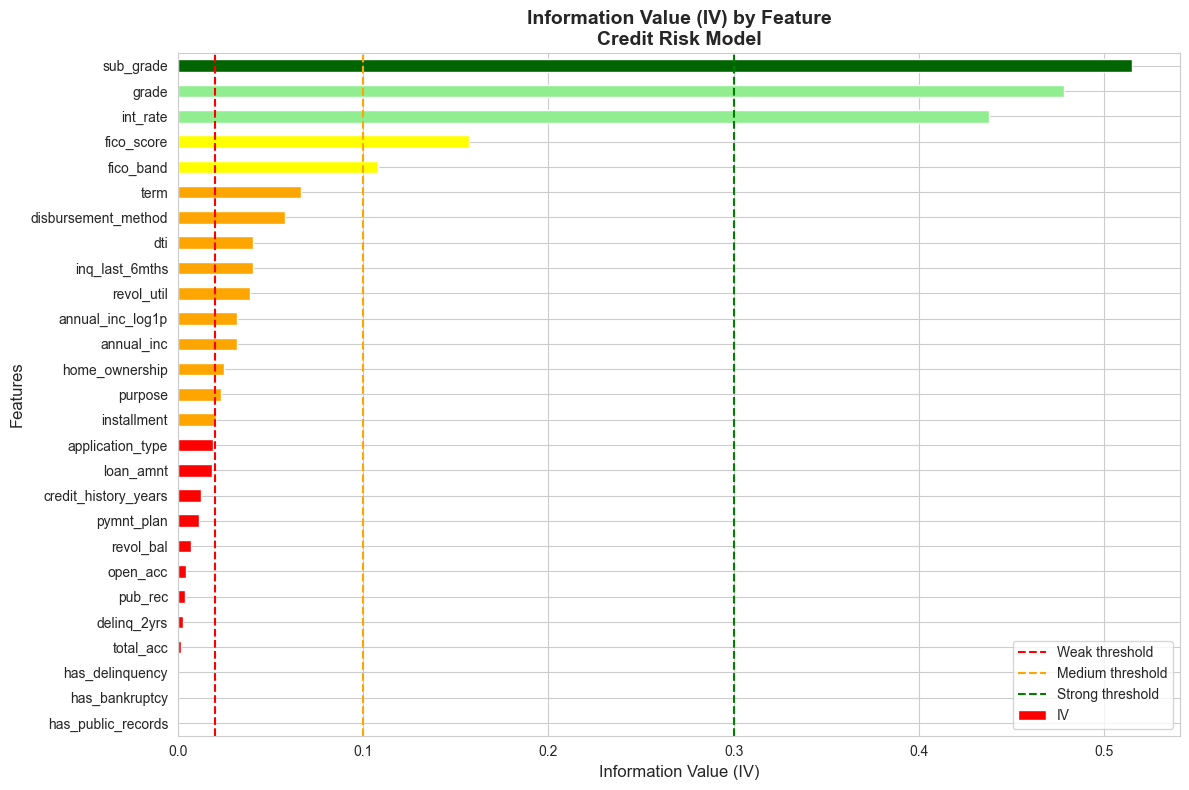


IV Summary Statistics:
              IV
count  27.000000
mean    0.079772
std     0.147742
min     0.000000
25%     0.005763
50%     0.023109
75%     0.049175
max     0.515099


In [9]:
# Plot IV scores
fig, ax = plt.subplots(figsize=(12, 8))
iv_df_sorted = iv_df.sort_values('IV', ascending=True)

# Color code by IV strength
colors = []
for iv in iv_df_sorted['IV']:
    if iv < 0.02:
        colors.append('red')
    elif iv < 0.1:
        colors.append('orange')
    elif iv < 0.3:
        colors.append('yellow')
    elif iv < 0.5:
        colors.append('lightgreen')
    else:
        colors.append('darkgreen')

iv_df_sorted['IV'].plot(kind='barh', ax=ax, color=colors)
ax.set_xlabel('Information Value (IV)', fontsize=12)
ax.set_ylabel('Features', fontsize=12)
ax.set_title('Information Value (IV) by Feature\nCredit Risk Model', fontsize=14, fontweight='bold')
ax.axvline(x=0.02, color='red', linestyle='--', label='Weak threshold')
ax.axvline(x=0.1, color='orange', linestyle='--', label='Medium threshold')
ax.axvline(x=0.3, color='green', linestyle='--', label='Strong threshold')
ax.legend()
plt.tight_layout()
plt.show()

# Summary statistics
print("\nIV Summary Statistics:")
print(iv_df.describe())


In [10]:
# VIF (Variance Inflation Factor) to detect multicolinearity

numeric_features = [
    # Loan characteristics
    'loan_amnt', 'int_rate', 'installment',

    # Borrower financials
    'annual_inc', 'annual_inc_log1p', 'dti',

    # Credit bureau data
    'fico_score', 'delinq_2yrs', 'inq_last_6mths',
    'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
    'total_acc',

    # Engineered features
    'credit_history_years', 'has_delinquency',
    'has_public_records', 'has_bankruptcy'
]

# Prepare data without null values
df_vif = df[numeric_features]

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = numeric_features
vif_data["VIF"] = [variance_inflation_factor(df_vif.values, i)
                   for i in range(len(numeric_features))]

# Sort by VIF (highest to lowest)
vif_data = vif_data.sort_values('VIF', ascending=False)

print("VARIANCE INFLATION FACTOR (VIF) - Multicollinearity Analysis")
print(vif_data.to_string(index=False))
print("VIF Interpretation:")
print("  VIF = 1     : No correlation")
print("  VIF 1-5     : Moderate correlation")
print("  VIF 5-10    : High correlation")
print("  VIF > 10    : Severe multicollinearity (consider removing)")

# Identify features with high multicollinearity
high_vif = vif_data[vif_data['VIF'] > 10]
if len(high_vif) > 0:
    print(f"\n Features with HIGH multicollinearity (VIF > 10):")
    print(high_vif.to_string(index=False))
else:
    print("\nNo severe multicollinearity detected!")


VARIANCE INFLATION FACTOR (VIF) - Multicollinearity Analysis
             Feature        VIF
    annual_inc_log1p 359.596428
          fico_score 289.972371
         installment  36.784383
           loan_amnt  36.251343
           total_acc  11.672177
            open_acc  11.667534
            int_rate   9.802986
  has_public_records   7.553199
          revol_util   7.292228
credit_history_years   6.573597
      has_bankruptcy   4.278781
                 dti   3.254137
             pub_rec   3.196855
     has_delinquency   2.770454
         delinq_2yrs   2.497763
           revol_bal   2.026124
          annual_inc   1.730941
      inq_last_6mths   1.576528
VIF Interpretation:
  VIF = 1     : No correlation
  VIF 1-5     : Moderate correlation
  VIF 5-10    : High correlation
  VIF > 10    : Severe multicollinearity (consider removing)

 Features with HIGH multicollinearity (VIF > 10):
         Feature        VIF
annual_inc_log1p 359.596428
      fico_score 289.972371
     installme

#### Multicollinearity Analysis

We observed high VIF values (>10) between the following variable pairs:

1. **`installment` vs `loan_amnt`**
   - Decision: Remove `installment` (derived from loan amount and interest rate)

2. **`total_acc` vs `open_acc`**
   - Decision: Remove `total_acc` (less interpretable than open accounts)

3. **`annual_inc` vs `annual_inc_log1p`**
   - Decision: Remove `annual_inc`, retain `annual_inc_log1p` (normalized distribution)

**Final action:** The following features were excluded from the model to reduce multicollinearity: `installment`, `total_acc`, `annual_inc`.

Apart from that, we have
- **`sub_grade` vs `grade`**, where we have decided to keep `sub_grade`, which is a more granular version of grade.

- **`fico_score` vs `fico_band`**, where we have decided to keep `fico_score` for the same reason as aforementioned.

In [11]:
high_vif_vars = ['grade', 'installment', 'total_acc', 'annual_inc', 'fico_band']
model_features = [x for x in model_features if x not in high_vif_vars]

model_features

['loan_amnt',
 'int_rate',
 'annual_inc_log1p',
 'dti',
 'fico_score',
 'delinq_2yrs',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'credit_history_years',
 'has_delinquency',
 'has_public_records',
 'has_bankruptcy',
 'term',
 'pymnt_plan',
 'application_type',
 'disbursement_method',
 'sub_grade',
 'home_ownership',
 'purpose']

In [12]:
y = df['default']
X = df[model_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
# List of columns to
# WOE Encoder (will replace text in 'woe_cols' with numbers)
woe_cols = ['sub_grade', 'home_ownership', 'purpose']
woe_encoder = ce.WOEEncoder(cols=woe_cols, handle_unknown='value')

# OneHot Encoder (will replace text in 'ohe_cols' with 0/1 columns)
ohe_cols = ['term', 'pymnt_plan', 'application_type', 'disbursement_method']
ohe_encoder = ce.OneHotEncoder(cols=ohe_cols, use_cat_names=True)

X_train_woe = woe_encoder.fit_transform(X_train, y_train)
X_test_woe = woe_encoder.transform(X_test)

# Apply One-Hot to the result of Step A
X_train_encoded = ohe_encoder.fit_transform(X_train_woe)
X_test_encoded = ohe_encoder.transform(X_test_woe)

# Standard scaling for the sake of the Logistic Regression
scaler = StandardScaler()
X_train_final = scaler.fit_transform(X_train_encoded)
X_test_final = scaler.transform(X_test_encoded)

In [14]:
print(f"Default rate: {y_train.mean():.2%}")

Default rate: 12.86%


Since the class balance is OK (`y_train`mean > 5%) we do not need to rebalance it using SMOTE.

In [15]:
X_train_balanced = X_train_final
y_train_balanced = y_train

In [17]:
# Quick RF to see feature importance
rf_quick = RandomForestClassifier(n_estimators=100, random_state=42)
rf_quick.fit(X_train_final, y_train)

# Plot importances
feature_importance = pd.DataFrame({
    'feature': X_train_encoded.columns,
    'importance': rf_quick.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(15))


                 feature  importance
3                    dti    0.107867
9              revol_bal    0.107142
11  credit_history_years    0.105649
10            revol_util    0.103969
2       annual_inc_log1p    0.092780
1               int_rate    0.087193
0              loan_amnt    0.084001
7               open_acc    0.068962
4             fico_score    0.058662
23             sub_grade    0.055701
25               purpose    0.030093
6         inq_last_6mths    0.020053
5            delinq_2yrs    0.016135
24        home_ownership    0.014561
8                pub_rec    0.009967


In [21]:
feature_importance[feature_importance['importance']>0.01]

,feature,importance
3,dti,0.107867
9,revol_bal,0.107142
11,credit_history_years,0.105649
10,revol_util,0.103969
2,annual_inc_log1p,0.092780
1,int_rate,0.087193
0,loan_amnt,0.084001
7,open_acc,0.068962
4,fico_score,0.058662
23,sub_grade,0.055701


In [23]:
# We keep all the features whose importance is greater than 1%
features = feature_importance[feature_importance['importance']>0.01]

print(f"\n Selected the features whose importance is >1% based on Random Forest:\n{features}")

# 2. Subset the ENCODED (but unscaled) data
# We assume 'X_train_encoded' and 'X_test_encoded' are available from previous cells
X_train_reduced_unscaled = X_train_encoded[features]
X_test_reduced_unscaled = X_test_encoded[features]

# 3. Fit a NEW Scaler for these specific features (Critical for production)
std_scaler = StandardScaler()
X_train_ready = std_scaler.fit_transform(X_train_reduced_unscaled)
X_test_ready = std_scaler.transform(X_test_reduced_unscaled)

# Since SMOTE is not needed, we use the natural targets
y_train_ready = y_train
y_test_ready = y_test

print(f"Final training shape: {X_train_ready.shape}")

# 4. Save artifacts for modeling
Path("data/processed").mkdir(parents=True, exist_ok=True)
Path("models").mkdir(parents=True, exist_ok=True)

# Save the reduced scaler
joblib.dump(std_scaler, 'models/features.pkl')
# Save the encoders for production
joblib.dump(woe_encoder, 'models/woe_encoder.pkl')
joblib.dump(ohe_encoder, 'models/ohe_encoder.pkl')

# Save data dictionary
artifacts = {
    "X_train": X_train_ready,
    "y_train": y_train_ready,
    "X_test": X_test_ready,
    "y_test": y_test_ready,
    "features": features
}

joblib.dump(artifacts, "data/processed/modeling_data.joblib")


 Selected the features whose importance is >1% based on Random Forest:
                 feature  importance
3                    dti    0.107867
9              revol_bal    0.107142
11  credit_history_years    0.105649
10            revol_util    0.103969
2       annual_inc_log1p    0.092780
1               int_rate    0.087193
0              loan_amnt    0.084001
7               open_acc    0.068962
4             fico_score    0.058662
23             sub_grade    0.055701
25               purpose    0.030093
6         inq_last_6mths    0.020053
5            delinq_2yrs    0.016135
24        home_ownership    0.014561


C:\Users\jose_\OneDrive\Escritorio\Proyecto Credit Risk\credit-risk-modeling\.venv\Lib\site-packages\sklearn\utils\extmath.py:1207: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\jose_\OneDrive\Escritorio\Proyecto Credit Risk\credit-risk-modeling\.venv\Lib\site-packages\sklearn\utils\extmath.py:1212: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\jose_\OneDrive\Escritorio\Proyecto Credit Risk\credit-risk-modeling\.venv\Lib\site-packages\sklearn\utils\extmath.py:1236: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Final training shape: (1808560, 26)


['data/processed/modeling_data.joblib']